In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import win32com.client
import sqlite3

import sys
from enum import Enum
import time
import pythoncom

import warnings
warnings.filterwarnings('ignore')

# matplotlib 그래프 한글지원
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False
if platform.system()== 'Windows':
    path= 'c:/Windows/Fonts/malgun.ttf'
    font_name= font_manager.FontProperties(fname=path).get_name()
    rc('font', family= font_name)
elif platform.system()=='Darwin':
    rc('font', family= 'AppleGothic')
else:
    print('포트를 지원하지 않습니다.')

In [91]:
# # 데이터 전체 로딩
# with sqlite3.connect('./data/StockData.sqlite') as conn:
#     df_일별주가= pd.read_sql("SELECT * From '기간별주가'", con=conn) # if_exists='append'
#     df_투자자= pd.read_sql("SELECT * From '종목별투자자'", con=conn) # if_exists='append'    

    

In [92]:
# 데이터 부분 로딩
code= 'A005380' # A005380
시작일자= '20120101'
종료일자= '20190201'

# query= """
#         SELECT 날짜, 시가, 고가, 저가, 종가, 거래량 FROM 기간별주가 WHERE 종목코드='%s' AND 날짜 BETWEEN '%s' AND '%s'
#         ORDER BY 날짜 ASC
#        """ %(code, 시작일자, 종료일자)
query= """
        SELECT 날짜, 시가, 고가, 저가, 종가, 거래량 FROM '코스피 일별주가' WHERE 종목코드='%s' AND 날짜 BETWEEN '%s' AND '%s'
        ORDER BY 날짜 ASC
       """ %(code, 시작일자, 종료일자)
# query= """
#         SELECT 종목코드, 날짜, 시가, 고가, 저가, 종가, 거래량 FROM '코스피 일별주가' WHERE 날짜 BETWEEN '%s' AND '%s'
#         ORDER BY 날짜 ASC
#        """ %(시작일자, 종료일자)


conn= sqlite3.connect('./data/StockData2.sqlite')
df= pd.read_sql_query(query, con=conn)
conn.close()

print(df.shape)
df.head()

(1744, 6)


,날짜,시가,고가,저가,종가,거래량
0,20120102,214000,215500,209500,212500,255312.0
1,20120103,215000,222500,214500,221500,666913.0
2,20120104,224000,228000,222500,223500,584416.0
3,20120105,224500,228000,223000,223500,527310.0
4,20120106,224000,224500,215000,219500,542671.0


In [93]:
df.tail()

,날짜,시가,고가,저가,종가,거래량
1739,20190128,128500,130000,125500,126500,541428.0
1740,20190129,126500,128500,126000,128000,445671.0
1741,20190130,128500,129500,126500,129500,463542.0
1742,20190131,130000,131000,128500,129500,509642.0
1743,20190201,129500,130000,128500,129500,392755.0


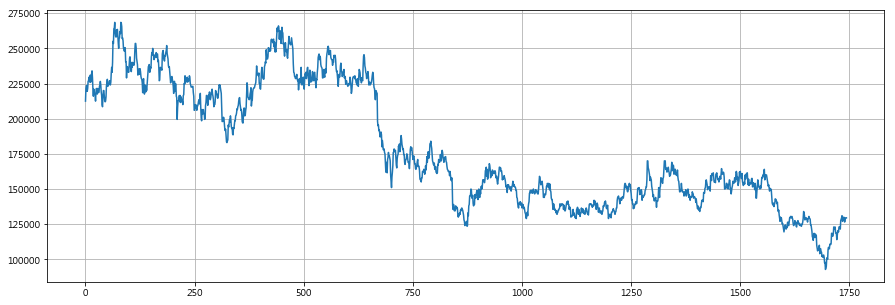

In [94]:
#df_graph= df.loc['20160302':'20181230']
df_graph= df.copy()
fig= plt.figure(figsize=(15,5))
ax1= fig.add_subplot(1,1,1)
ax1.plot(df_graph.index, df_graph['종가'])
ax1.grid()
plt.show()

In [95]:
# df[df['시가'] > 1000000].종목코드.unique()

In [96]:
# 기술적지표 추가
import talib as ta

#df['전일대비']= (df['종가']-df['종가'].shift(1))
#df['등락률']= (df['종가']-df['종가'].shift(1))/df['종가'].shift(1) * 100
#df['전일등락률'] = df['등락률'].shift(1)
# df['전일시가']= df['시가'].shift(1)
# df['전일고가']= df['고가'].shift(1)
# df['전일저가']= df['저가'].shift(1)  
# df['전일종가']= df['종가'].shift(1)  

# 이동평균선
# df['MA5']= df['종가'].rolling(window= 5).mean()
#df['전일MA5']= df['MA5'].shift(1)
# df['MA5']= df['종가'].rolling(window= 5).mean()
# df['MA20']= df['종가'].rolling(window= 20).mean()
# df['MADiff']= df['MA5'] - df['MA20']
df['MA15']= df['종가'].rolling(window= 15).mean()


# Stochastic_slow_k, Stochastic_slow_d (12,3,3) 모멘텀지표 (상하한)
df['SlowK'], df['SlowD'] = ta.STOCH(np.array(df['고가'].astype(float)), 
                                    np.array(df['저가'].astype(float)),
                                    np.array(df['종가'].astype(float)),
                                    fastk_period=12, slowk_period=3, slowk_matype=0, 
                                    slowd_period=3, slowd_matype=0)

# MACD_12_26 , sign, diff 추세지표
df['MACD'], df['MACDsign'], df['MACDhist'] = ta.MACD(np.array(df['종가'].astype(float)), 
                                                        fastperiod=12, slowperiod=26, signalperiod=9)

#  RSI_14 모멘텀지표 (상하한)
df['RSI14']= ta.RSI(np.array(df['종가'].astype(float)), timeperiod=14)     
#df['전일RSI']= df['RSI'].shift(1)    
    
# Williams_percent_r_14 모멘텀지표 (상하한)
df['WILR14'] = ta.WILLR(np.array(df['고가'].astype(float)),
                        np.array(df['저가'].astype(float)),
                        np.array(df['종가'].astype(float)))


# df['date']= pd.to_datetime(df['날짜'].values)
df.set_index('날짜', inplace= True)
df.dropna(inplace= True)


In [97]:
df.head(10)

,시가,고가,저가,종가,거래량,MA15,SlowK,SlowD,MACD,MACDsign,MACDhist,RSI14,WILR14
날짜,,,,,,,,,,,,,
20120220,226500,228000,223500,224000,560653.0,219300.000000,71.296182,64.246716,-906.647208,-1509.717851,603.070644,57.162524,-22.857143
20120221,225000,227000,223500,226500,431118.0,219666.666667,82.232143,72.500342,-404.897906,-1288.753862,883.855956,59.876635,-8.571429
20120222,227500,228500,221500,224000,449186.0,220033.333333,80.432900,77.987075,-206.605457,-1072.324181,865.718724,56.052086,-25.000000
20120223,224500,224500,217500,219000,553306.0,220100.000000,64.595158,75.753400,-447.754047,-947.410154,499.656108,49.273337,-52.777778
20120224,216000,218000,212500,216500,861826.0,220100.000000,42.452301,62.493453,-831.015716,-924.131267,93.115551,46.260844,-72.727273
20120227,214500,215000,207000,210000,1023577.0,219933.333333,22.861039,43.302833,-1640.340206,-1067.373054,-572.967151,39.499093,-86.046512
20120228,207000,210000,205000,208500,818030.0,219233.333333,17.949035,27.754125,-2375.391129,-1328.976669,-1046.414460,38.114573,-85.106383
20120229,209000,216000,209000,216000,761238.0,218866.666667,25.218539,22.009538,-2325.925144,-1528.366364,-797.558780,47.940372,-53.191489
20120302,222000,223500,220000,220000,1030467.0,218866.666667,41.843972,28.337182,-1941.575155,-1611.008122,-330.567032,52.291104,-36.170213


In [98]:
# Trend, Trend Value 컬럼추가 (추세지표)
# 추세 상향/하향/횡보 구분할수있는가? (라벨값)
# 하향,횡보일때는 매수X,매도O, 상향일때 매수O,매도X
# 하향의 조건?,# 횡보의 조건?,# 상향의 조건?
# 하향->횡보->상향->횡보->상향, 추세를 바뀌었다는것을 알수있는 delay기간은? 최소화, 기간이 길수록 알아내기 쉽다.
# 인간은? 과거의 주가들, 거래량, 기술적지표들 -> 정확히알수없다 -> 마지막으로 미래의 주가!!!를 보고 판단 -> 타겟값작성(수기 또는 조건)
# 과거 몇일? 5일 미래 몇일? 2~3일
# 횡보에서 상향으로 바뀔때 매수, 횡보에서 매도로 바뀔때 매도

# MA15 과거 5일 컬럼 생성
df_trend = df[['종가','MA15']]
for i in range(1,6):
    df_trend.loc[:, 'MA15_P' + str(i)]= df_trend['MA15'].shift(i)
df_trend.dropna(inplace= True)    

# 추세지표(Trend) 생성
trend_state=[]

for i in range(df_trend.shape[0]):
    row_list=[]
    for j in range(1,df_trend.shape[1]):
        row_list.append(df_trend.iloc[i, j])
    # MA15가 지난5일간 MA15의 최대치일때, 그리고 현종가가 MA15보다 클때
    if (row_list[0] == np.array(row_list).max()) and (df_trend.iloc[i,0] > df_trend.iloc[i,1]):
        trend_state.append('up')
    # MA15가 지난5일간 MA15의 최소치일때, 그리고 현종가가 MA15보다 작을때
    elif(row_list[0] == np.array(row_list).min()) and (df_trend.iloc[i,0] < df_trend.iloc[i,1]):
        trend_state.append('down')
    else:
        trend_state.append('no')
    
df_trend['Trend']= pd.Series(trend_state, index= df_trend.index)    

In [99]:
print(df_trend.shape)
df_trend.head(10)

(1706, 8)


,종가,MA15,MA15_P1,MA15_P2,MA15_P3,MA15_P4,MA15_P5,Trend
날짜,,,,,,,,
20120227,210000,219933.333333,220100.000000,220100.000000,220033.333333,219666.666667,219300.000000,no
20120228,208500,219233.333333,219933.333333,220100.000000,220100.000000,220033.333333,219666.666667,down
20120229,216000,218866.666667,219233.333333,219933.333333,220100.000000,220100.000000,220033.333333,down
20120302,220000,218866.666667,218866.666667,219233.333333,219933.333333,220100.000000,220100.000000,no
20120305,220000,219033.333333,218866.666667,218866.666667,219233.333333,219933.333333,220100.000000,no
20120306,216500,218700.000000,219033.333333,218866.666667,218866.666667,219233.333333,219933.333333,down
20120307,213000,218300.000000,218700.000000,219033.333333,218866.666667,218866.666667,219233.333333,down
20120308,212000,217866.666667,218300.000000,218700.000000,219033.333333,218866.666667,218866.666667,down
20120309,212500,217433.333333,217866.666667,218300.000000,218700.000000,219033.333333,218866.666667,down


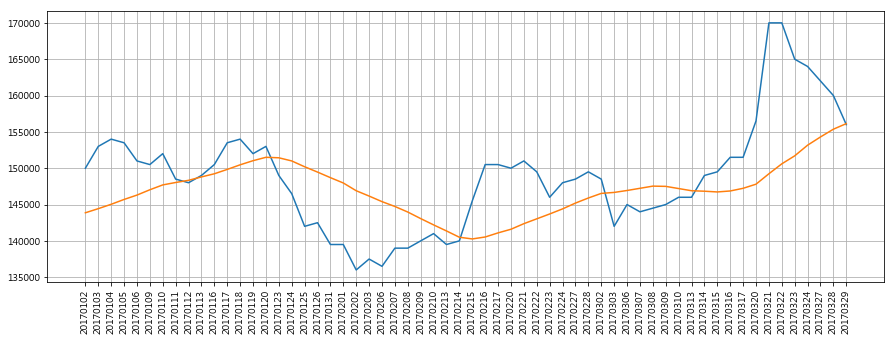

In [100]:
df_graph= df.loc['20170102':'20170329']
#df_graph= df.copy()
fig= plt.figure(figsize=(15,5))
ax1= fig.add_subplot(1,1,1)
plt.xticks(rotation=90)
ax1.plot(df_graph.index, df_graph['종가'])
ax1.plot(df_graph.index, df_graph['MA15'])
#ax1.plot(df_graph.index, df_graph['MA20'])
ax1.grid()
plt.show()

In [101]:
# 종가 미래 2일 컬럼 생성
df_ts = df_trend[['종가','Trend']]
for i in range(1,3):
    df_ts.loc[:, '종가_F' + str(i)]= df_ts['종가'].shift(-1*i)
df_ts.dropna(inplace= True)

# 트렌드 및 종가로 트레이딩 시그널 값 생성
trading_signal= []
for i in range(df_ts.shape[0]):
    row_list=[]
    for j in [0,2,3]:
        row_list.append(df_ts.iloc[i, j])
    max_cp= np.array(row_list).max()
    min_cp= np.array(row_list).min()
    if df_ts.iloc[i,1] == 'up':
        ts_value= ((max_cp - row_list[0])/(max_cp-min_cp)*0.5) + 0.5   
    else:
        ts_value= ((max_cp - row_list[0])/(max_cp-min_cp)*0.5)
    trading_signal.append(ts_value)

df_ts['Trading signal']= pd.Series(trading_signal, index= df_ts.index)    

In [102]:
print(df_ts.shape)
df_ts[-508:-490]

(1704, 5)


,종가,Trend,종가_F1,종가_F2,Trading signal
날짜,,,,,
20170102,150000,up,153000.0,154000.0,1.000000
20170103,153000,up,154000.0,153500.0,1.000000
20170104,154000,up,153500.0,151000.0,0.500000
20170105,153500,up,151000.0,150500.0,0.500000
20170106,151000,up,150500.0,152000.0,0.833333
20170109,150500,up,152000.0,148500.0,0.714286
20170110,152000,up,148500.0,148000.0,0.500000
20170111,148500,up,148000.0,149000.0,0.750000
20170112,148000,no,149000.0,150500.0,0.500000


In [103]:
# 기존 df에 Trend지표와 Trading signal 컬럼을 합친다.
df= pd.merge(df, df_ts[['Trend','Trading signal']], on='날짜', how='inner') # 

In [104]:
print(df.shape)
df.head()

(1704, 15)


,시가,고가,저가,종가,거래량,MA15,SlowK,SlowD,MACD,MACDsign,MACDhist,RSI14,WILR14,Trend,Trading signal
날짜,,,,,,,,,,,,,,,
20120227,214500,215000,207000,210000,1023577.0,219933.333333,22.861039,43.302833,-1640.340206,-1067.373054,-572.967151,39.499093,-86.046512,no,0.4
20120228,207000,210000,205000,208500,818030.0,219233.333333,17.949035,27.754125,-2375.391129,-1328.976669,-1046.414460,38.114573,-85.106383,down,0.5
20120229,209000,216000,209000,216000,761238.0,218866.666667,25.218539,22.009538,-2325.925144,-1528.366364,-797.558780,47.940372,-53.191489,down,0.5
20120302,222000,223500,220000,220000,1030467.0,218866.666667,41.843972,28.337182,-1941.575155,-1611.008122,-330.567032,52.291104,-36.170213,no,0.0
20120305,220500,223000,218000,220000,478789.0,219033.333333,58.156028,41.739513,-1618.320033,-1612.470504,-5.849528,52.291104,-36.170213,no,0.0


In [105]:
df['Trading signal'].mean()  # 0.38124551984650457

0.40189734423069623

In [106]:
# df['Trend2'] = np.where(df['Trading signal'] > 0.4, 1, -1)
# df['Trend2_P1']= df['Trend2'].shift(1)
# df.dropna(inplace= True)

In [107]:
df.columns

Index(['시가', '고가', '저가', '종가', '거래량', 'MA15', 'SlowK', 'SlowD', 'MACD',
       'MACDsign', 'MACDhist', 'RSI14', 'WILR14', 'Trend', 'Trading signal',
       'Trend2'],
      dtype='object')

In [111]:
df2= df[['종가', '거래량', 'MA15', 'SlowK',
       'SlowD', 'MACD', 'MACDsign', 'MACDhist', 'RSI14', 'WILR14','Trend','Trading signal']]

In [112]:
df2['Trend'].replace(['down','no','up'], [0,1,2], inplace= True)

In [113]:
df2.head()

,종가,거래량,MA15,SlowK,SlowD,MACD,MACDsign,MACDhist,RSI14,WILR14,Trend,Trading signal
날짜,,,,,,,,,,,,
20120227,210000,1023577.0,219933.333333,22.861039,43.302833,-1640.340206,-1067.373054,-572.967151,39.499093,-86.046512,1,0.4
20120228,208500,818030.0,219233.333333,17.949035,27.754125,-2375.391129,-1328.976669,-1046.414460,38.114573,-85.106383,0,0.5
20120229,216000,761238.0,218866.666667,25.218539,22.009538,-2325.925144,-1528.366364,-797.558780,47.940372,-53.191489,0,0.5
20120302,220000,1030467.0,218866.666667,41.843972,28.337182,-1941.575155,-1611.008122,-330.567032,52.291104,-36.170213,1,0.0
20120305,220000,478789.0,219033.333333,58.156028,41.739513,-1618.320033,-1612.470504,-5.849528,52.291104,-36.170213,1,0.0


In [114]:
#스케일링
from sklearn.preprocessing import MinMaxScaler

scaler_list=[]
for col in df2.columns[:-1]:
    scaler= MinMaxScaler()
    df2[col]= scaler.fit_transform(df2[col].values.reshape(-1,1)).reshape(-1,)
    scaler_list.append(scaler)

# 더정확하게 스케일링 학습셋먼저한다음 테스트셋 하기 
    

In [115]:
print(df2.shape)
df2.head()

(1704, 12)


,종가,거래량,MA15,SlowK,SlowD,MACD,MACDsign,MACDhist,RSI14,WILR14,Trend,Trading signal
날짜,,,,,,,,,,,,
20120227,0.667046,0.205164,0.743971,0.224361,0.435286,0.442448,0.487085,0.394478,0.354799,0.139535,0.5,0.4
20120228,0.658509,0.156096,0.739635,0.174119,0.270449,0.410613,0.474609,0.334512,0.333074,0.148936,0.0,0.5
20120229,0.701195,0.142539,0.737364,0.248475,0.209548,0.412755,0.465100,0.366031,0.487252,0.468085,0.0,0.5
20120302,0.723961,0.206809,0.737364,0.418527,0.276630,0.429401,0.461159,0.425180,0.555520,0.638298,0.5,0.0
20120305,0.723961,0.075114,0.738396,0.585373,0.418713,0.443401,0.461089,0.466308,0.555520,0.638298,0.5,0.0


In [116]:
df2.dropna(inplace= True)

In [117]:
df2.isnull().sum()

종가                0
거래량               0
MA15              0
SlowK             0
SlowD             0
MACD              0
MACDsign          0
MACDhist          0
RSI14             0
WILR14            0
Trend             0
Trading signal    0
dtype: int64

In [118]:
X= df2[df2.columns[:-1]]
Y= df2[df2.columns[-1]]

In [119]:
# Train Set과 Test Set 나누기
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle= False)

In [120]:
# 모델학습
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [121]:
from sklearn.ensemble import RandomForestRegressor

rf= RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(train_X, train_Y)
print('훈련 세트 정확도: {:.3f}'.format(rf.score(train_X, train_Y)))
print('테스트 세트 정확도: {:.3f}'.format(rf.score(test_X, test_Y)))


훈련 세트 정확도: 0.931
테스트 세트 정확도: 0.463


Text(0, 0.5, 'feature')

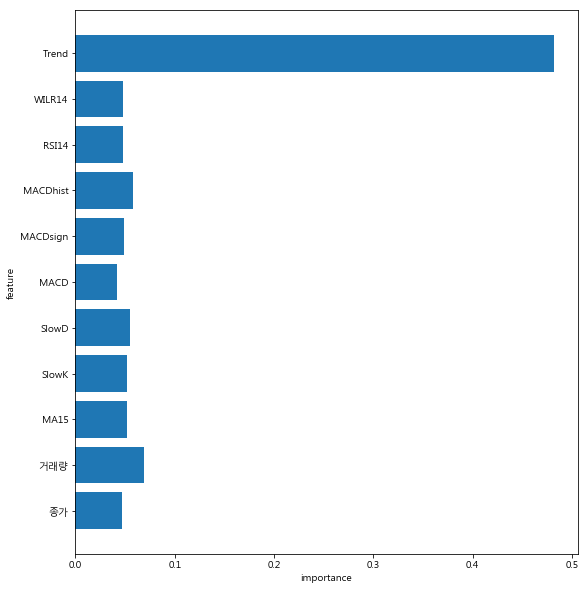

In [122]:
n_features= train_X.shape[1]

fig= plt.figure(figsize=(9,10))
plt.barh(range(n_features), rf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), train_X.columns)
plt.xlabel('importance')
plt.ylabel('feature')
#plt.ylim(-1, n_features)


In [123]:
# prediction= rf.predict(test_X)
# print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction, test_Y))

In [124]:
import keras
from keras import layers, models, optimizers
import random as rd
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from sklearn.metrics import accuracy_score
from keras.utils import np_utils


In [125]:
# 모델1
np.random.seed(5)

keras.backend.clear_session()
model = keras.models.Sequential()

model.add( layers.Dense(14, input_shape=(train_X.shape[1],), activation='relu' ))
#model.add( layers.Dense(10, activation='relu' ))
#model.add( layers.Dense(5, activation='relu' ))
model.add( layers.Dense(1) )

adam = optimizers.Adam(lr=0.01, decay=0.0001)
model.compile(loss = 'mse', optimizer = 'adam', metrics =['accuracy']) 
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 14)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


In [126]:
history = model.fit(train_X, train_Y, epochs= 200, verbose=1, batch_size = 50,
                    validation_data=(test_X, test_Y))


Train on 1187 samples, validate on 509 samples
Epoch 1/200
1187/1187 [==============================] - 0s 174us/step - loss: 0.2510 - acc: 0.2738 - val_loss: 0.1702 - val_acc: 0.2731
Epoch 2/200
1187/1187 [==============================] - 0s 16us/step - loss: 0.1287 - acc: 0.2738 - val_loss: 0.1102 - val_acc: 0.2731
Epoch 3/200
1187/1187 [==============================] - 0s 16us/step - loss: 0.0889 - acc: 0.2772 - val_loss: 0.0871 - val_acc: 0.2731
Epoch 4/200
1187/1187 [==============================] - 0s 15us/step - loss: 0.0798 - acc: 0.3184 - val_loss: 0.0818 - val_acc: 0.2947
Epoch 5/200
1187/1187 [==============================] - 0s 14us/step - loss: 0.0774 - acc: 0.3471 - val_loss: 0.0798 - val_acc: 0.3399
Epoch 6/200
1187/1187 [==============================] - 0s 14us/step - loss: 0.0743 - acc: 0.3513 - val_loss: 0.0773 - val_acc: 0.3576
Epoch 7/200
1187/1187 [==============================] - 0s 13us/step - loss: 0.0719 - acc: 0.3665 - val_loss: 0.0744 - val_acc: 0.3851


Epoch 120/200
1187/1187 [==============================] - 0s 15us/step - loss: 0.0503 - acc: 0.3816 - val_loss: 0.0560 - val_acc: 0.3949
Epoch 121/200
1187/1187 [==============================] - 0s 15us/step - loss: 0.0502 - acc: 0.3816 - val_loss: 0.0561 - val_acc: 0.3929
Epoch 122/200
1187/1187 [==============================] - 0s 14us/step - loss: 0.0502 - acc: 0.3816 - val_loss: 0.0560 - val_acc: 0.3949
Epoch 123/200
1187/1187 [==============================] - 0s 14us/step - loss: 0.0504 - acc: 0.3816 - val_loss: 0.0560 - val_acc: 0.3949
Epoch 124/200
1187/1187 [==============================] - 0s 13us/step - loss: 0.0511 - acc: 0.3816 - val_loss: 0.0565 - val_acc: 0.3929
Epoch 125/200
1187/1187 [==============================] - 0s 15us/step - loss: 0.0502 - acc: 0.3816 - val_loss: 0.0560 - val_acc: 0.3949
Epoch 126/200
1187/1187 [==============================] - 0s 14us/step - loss: 0.0500 - acc: 0.3816 - val_loss: 0.0560 - val_acc: 0.3949
Epoch 127/200
1187/1187 [=========

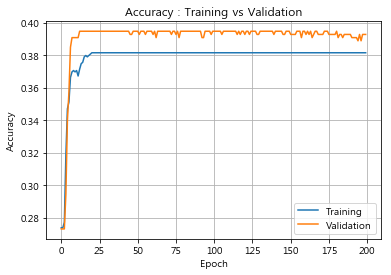

In [127]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.grid()
plt.show()

In [150]:
prediction = model.predict(test_X).reshape(-1,)

In [151]:
# s1= pd.Series(prediction)
# s2= pd.Series(test_Y.values)
# result_df= pd.DataFrame(s1)
# result_df.columns=['pred']
# result_df['ytest']= s2
test_X2= test_X[['Trend']]
#test_X2= test_X[['종가']]
test_X2['pred']= pd.Series(prediction, index=test_X2.index)
test_X2['real']= pd.Series(test_Y.values, index=test_X2.index)


In [152]:
test_X2['pred'].mean()  # 0.2287

0.4139645993709564

In [153]:
test_X2.head()

,Trend,pred,real
날짜,,,
20161221,1.0,0.746809,0.625
20161222,1.0,0.755987,1.000
20161223,1.0,0.776776,1.000
20161226,1.0,0.764041,0.500
20161227,1.0,0.754957,0.800


(509, 4)


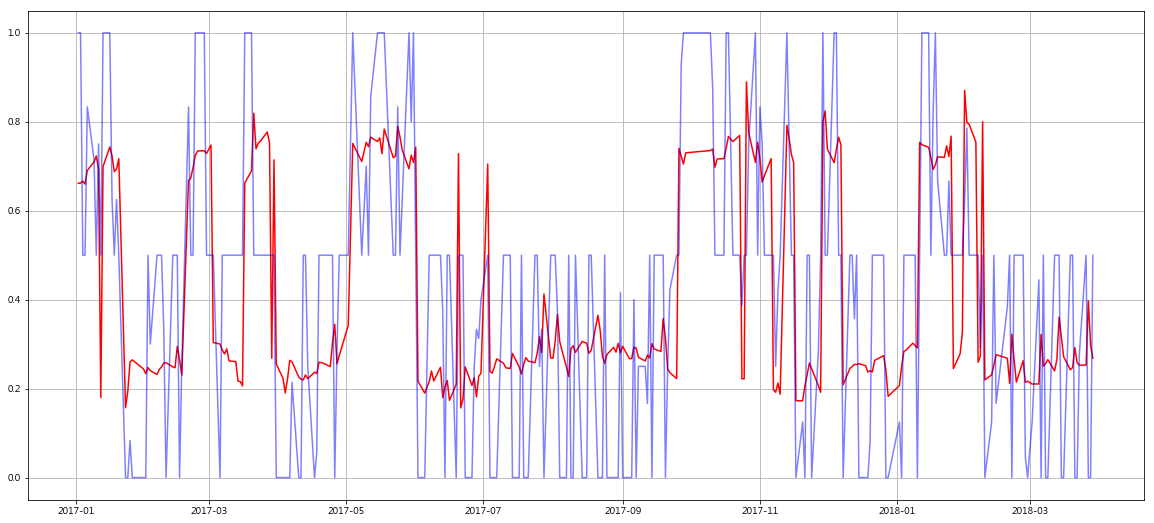

In [154]:
test_X2['date']= pd.to_datetime(test_X2.index)
print(test_X2.shape)
#tf= test_X2.loc['20110302':'20190329']
tf= test_X2.loc['20170102':'20180329']
fig= plt.figure(figsize=(20,9))
ax1= fig.add_subplot(1,1,1)
ax1.plot(tf.date, tf['pred'], color='r')
ax1.plot(tf.date, tf['real'], color='b', alpha=0.5)
ax1.grid()
plt.show()


In [155]:
#tf[250:]

In [156]:
test_X2= test_X2.join(df[['시가','종가']])

In [157]:
test_X2['Trend2'] = np.where(test_X2['pred'] > 0.5, 1, -1)
test_X2['Trend2_P1']= test_X2['Trend2'].shift(1)
test_X2.dropna(inplace= True)

In [159]:
# 함수구조를 2단계로 나누자.
# 전략실행-> buy(1), sell(-1), hold(0)로 구분 -> Trading Signal 컬럼생성 
# 백테스팅실행 -> Trading Signal 컬럼값을 바탕으로

def STRATEGY_Run(df_local=None):
    
    ts_list=[]
    trading_state= 0 # 매수후1, 매도후 0
    
#     for idate, row in df_local[['시가','종가','MA20','전일MA20']].iterrows():
#         trading_signal= 0 # 매수1, 매도-1
#         시가, 종가, MA20, 전일MA20 = row        
#         매수조건 = 시가 > 전일MA20
#         if 매수조건== True and trading_state == 0:
#             trading_signal= 1
#             trading_state= 1
#         매도조건 = 시가 < 전일MA20
#         if 매도조건== True and trading_state == 1:
#             trading_signal= -1
#             trading_state= 0

    for idate, row in df_local[['시가','종가','Trend2','Trend2_P1']].iterrows():
        trading_signal= 0 # 매수1, 매도-1
        시가, 종가, Trend2, Trend2_P1 = row        
        매수조건 = Trend2 > Trend2_P1
        if 매수조건== True and trading_state == 0:
            trading_signal= 1
            trading_state= 1
        매도조건 = Trend2 < Trend2_P1
        if 매도조건== True and trading_state == 1:
            trading_signal= -1
            trading_state= 0
            
        ts_list.append(trading_signal)          
    
    return ts_list


# 백테스트 실행
def BACKTEST_Run(df_local=None, 투자시작일=None, 투자종료일=None, 투자금=10000000):
    
    df_local= df_local.loc[투자시작일:투자종료일]
    portfolio = []  # 매수시 [일자, 매수가, 수량]
    거래결과 = [] # 매도시 [매수가, 매도가, 수익, 수익률]
    계좌평가결과 = [] # [일자, 현재가, 매수가, 매도가, 수량, 매수금액, 평가금액, 투자금, 총자산, buy, sell]


    for idate, row in df_local[['시가','종가','TS']].iterrows():
        시가, 종가, trading_signal = row
        매도가= 0
        매수가2= 0
        #print(trading_signal)
        
        # 매수
        ##############################################################
        if trading_signal == 1 and len(portfolio) == 0:
            매수가 = 종가 
            매수가2 = 종가  ## 추가
            수량 = 투자금 // 종가 
            투자금 = 투자금 - int((매수가 * 수량) * (1+0.00015))
            portfolio = [idate, 매수가, 수량]

        # 매도
        ##############################################################
        if trading_signal == -1 and len(portfolio) > 0:
            매도가 = 종가
            [매수일,매수가,수량] = portfolio
            수익 = int((매도가 * 수량) * (1-0.00315)) - int((매수가 * 수량) * (1+0.00015))
            # 수익 = (매도가 - 매수가) * 수량
            수익률 = round(((매도가 - 매수가) / 매수가 *100 - 0.33), 2) ## 추가
            투자금 = 투자금 + int((매도가 * 수량) * (1-0.00315))
            portfolio = []           
            #거래결과.append([idate, 매수가, 매도가, 수량, 수익, 투자금])
            거래결과.append([idate, 매수가, 매도가, 수익, 수익률])
            
        # 매일 계좌 평가하여 기록
        ##############################################################
        if len(portfolio) > 0:
            [매수일,매수가,수량] = portfolio
            매수금액 = 매수가 * 수량
            평가금액 = 종가 * 수량
            총자산 = 투자금 + 평가금액
        else:
            매수가 = 0
            수량 = 0
            매수금액 = 0
            평가금액 = 0
            총자산 = 투자금
            
        계좌평가결과.append([idate, 종가, 매수가2, 매도가, 수량, 매수금액, 평가금액, 투자금, 총자산, trading_signal])

        
    # 거래의 최종 결과
    if (len(df_local) > 0) :
        #거래결과.append([df_local.index[-1], 0, 0, 0, 0, 투자금])
        #거래결과 = pd.DataFrame(data=거래결과, columns=['일자','매수가','매도가','수량','수익','투자금'])
        거래결과 = pd.DataFrame(data=거래결과, columns=['일자','매수가','매도가','수익','수익률'])
        거래결과.set_index('일자', inplace=True)
        
        계좌평가결과 = pd.DataFrame(data=계좌평가결과, columns=['일자','현재가','매수가','매도가','수량','매수금액',                                                    
                                                                '평가금액','투자금','총자산','TS'])
        
        계좌평가결과.set_index('일자', inplace=True)
#         계좌평가결과['MA20'] = self.계좌평가결과['현재가'].rolling(window=60).mean()
#         계좌평가결과['총자산MA60'] = self.계좌평가결과['총자산'].rolling(window=60).mean()            
        return (거래결과, 계좌평가결과)
    else:
        return (0, 0)

    

In [160]:
signal_list= STRATEGY_Run(df_local=test_X2)
print(len(signal_list))
test_X2['TS']= pd.Series(signal_list, index= test_X2.index)

508


In [161]:
test_X2.head(20)

,Trend,pred,real,date,시가,종가,Trend2,Trend2_P1,TS
날짜,,,,,,,,,
20161222,1.0,0.755987,1.000000,2016-12-22,143000,142000,1,1.0,0
20161223,1.0,0.776776,1.000000,2016-12-23,143000,144000,1,1.0,0
20161226,1.0,0.764041,0.500000,2016-12-26,143500,144500,1,1.0,0
20161227,1.0,0.754957,0.800000,2016-12-27,144500,144500,1,1.0,0
20161228,1.0,0.713285,1.000000,2016-12-28,142500,143500,1,1.0,0
20161229,1.0,0.691782,1.000000,2016-12-29,142500,146000,1,1.0,0
20170102,1.0,0.661652,1.000000,2017-01-02,146000,150000,1,1.0,0
20170103,1.0,0.662099,1.000000,2017-01-03,151000,153000,1,1.0,0
20170104,1.0,0.666617,0.500000,2017-01-04,152500,154000,1,1.0,0


In [162]:
거래결과, 계좌평가결과= BACKTEST_Run(df_local=test_X2, 투자시작일='20150101', 투자종료일='20190101', 투자금=10000000)

In [163]:
거래결과.head()

,매수가,매도가,수익,수익률
일자,,,,
20170123,149000,149000,-32944,-0.33
20170303,150000,142000,-559007,-5.66
20170329,151500,156000,247125,2.64
20170331,158500,157500,-91194,-0.96
20170602,152000,163000,648753,6.91


In [164]:
거래결과.tail(30)

,매수가,매도가,수익,수익률
일자,,,,
20170123,149000,149000,-32944,-0.33
20170303,150000,142000,-559007,-5.66
20170329,151500,156000,247125,2.64
20170331,158500,157500,-91194,-0.96
20170602,152000,163000,648753,6.91
20170621,166500,160500,-398364,-3.93
20170704,163500,158500,-331428,-3.39
20171024,147500,151000,192142,2.04
20171107,159500,155000,-300730,-3.15


In [165]:
print('거래횟수:',len(거래결과), '/', len(계좌평가결과))
print('수익합:', 거래결과['수익'].sum())
print('수익률합:', 거래결과['수익률'].sum()) 
# real: 82%

거래횟수: 20 / 489
수익합: -2291614
수익률합: -25.33


In [166]:
계좌평가결과.head(20)

,현재가,매수가,매도가,수량,매수금액,평가금액,투자금,총자산,TS
일자,,,,,,,,,
20161222,142000,0,0,0,0,0,10000000,10000000,0
20161223,144000,0,0,0,0,0,10000000,10000000,0
20161226,144500,0,0,0,0,0,10000000,10000000,0
20161227,144500,0,0,0,0,0,10000000,10000000,0
20161228,143500,0,0,0,0,0,10000000,10000000,0
20161229,146000,0,0,0,0,0,10000000,10000000,0
20170102,150000,0,0,0,0,0,10000000,10000000,0
20170103,153000,0,0,0,0,0,10000000,10000000,0
20170104,154000,0,0,0,0,0,10000000,10000000,0


In [167]:
계좌평가결과.tail(20)

,현재가,매수가,매도가,수량,매수금액,평가금액,투자금,총자산,TS
일자,,,,,,,,,
20181130,107000,0,0,0,0,0,7708386,7708386,0
20181203,108500,0,0,0,0,0,7708386,7708386,0
20181204,107500,107500,0,71,7632500,7632500,74742,7707242,1
20181205,107500,0,0,71,7632500,7632500,74742,7707242,0
20181206,110500,0,0,71,7632500,7845500,74742,7920242,0
20181207,111000,0,0,71,7632500,7881000,74742,7955742,0
20181210,110500,0,0,71,7632500,7845500,74742,7920242,0
20181211,111500,0,0,71,7632500,7916500,74742,7991242,0
20181212,118500,0,0,71,7632500,8413500,74742,8488242,0


In [168]:
계좌평가결과['date']= pd.to_datetime(계좌평가결과.index)

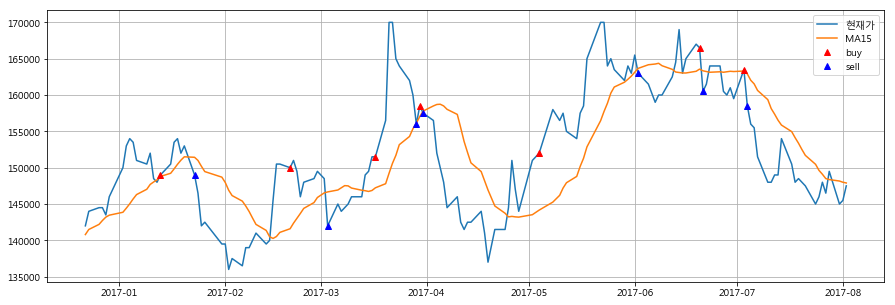

In [169]:
# 그래프 그리기
# 특정기간만 보기
df_graph= 계좌평가결과.loc['20160302':'20170802']
fig= plt.figure(figsize=(15,5))
ax1= fig.add_subplot(1,1,1)
ax1.plot(df_graph['date'], df_graph['현재가'])
ax1.plot(df_graph['date'], df.loc[df_graph.index]['MA15'])
ax1.plot(df_graph[df_graph['TS']==1]['date'], df_graph[df_graph['TS']==1]['매수가'], '^', color='r', label='buy')
ax1.plot(df_graph[df_graph['TS']==-1]['date'], df_graph[df_graph['TS']==-1]['매도가'], '^', color='b', label='sell')
ax1.legend(loc='best')
ax1.grid()
plt.show()

In [ ]:
# 백테스트 실행
def BACKTEST_Run(df_local=None, 투자시작일=None, 투자종료일=None, 투자금=10000000):
    
    df_local= df_local.loc[투자시작일:투자종료일]
    portfolio = []  # 매수시 [일자, 매수가, 수량]
    거래결과 = [] # 매도시 [매수가, 매도가, 수익, 수익률]
    계좌평가결과 = [] # [일자, 현재가, 매수가, 매도가, 수량, 매수금액, 평가금액, 투자금, 총자산, buy, sell]


    for idate, row in df_local[['시가','종가','MA20','전일MA20']].iterrows():
        시가, 종가, MA20, 전일MA20 = row
        buy= 0 # 매수시점표시
        sell= 0 # 매도시점표시
        매도가= 0
        매수가2= 0
        
        # 매수
        ##############################################################
        매수조건 = 시가 > 전일MA20 #and 전일MA20 > 전일MA240
        if 매수조건 == True and len(portfolio) == 0:
            buy=1 ## 추가
            매수가 = 시가 
            매수가2 = 시가  ## 추가
            수량 = 투자금 // 시가 
            투자금 = 투자금 - int((매수가 * 수량) * (1+0.00015))
            portfolio = [idate, 매수가, 수량]

        # 매도
        ##############################################################
        매도조건 = 시가 < 전일MA20
        if 매도조건 == True and len(portfolio) > 0:
            sell=1 ## 추가
            매도가 = 시가
            [매수일,매수가,수량] = portfolio
            수익 = int((매도가 * 수량) * (1-0.00315)) - int((매수가 * 수량) * (1+0.00015))
            # 수익 = (매도가 - 매수가) * 수량
            수익률 = round(((매도가 - 매수가) / 매수가 *100 - 0.33), 2) ## 추가
            투자금 = 투자금 + int((매도가 * 수량) * (1-0.00315))
            portfolio = []             
            #거래결과.append([idate, 매수가, 매도가, 수량, 수익, 투자금])
            거래결과.append([idate, 매수가, 매도가, 수익, 수익률])       
            
        # 매일 계좌 평가하여 기록
        ##############################################################
        if len(portfolio) > 0:
            [매수일,매수가,수량] = portfolio
            매수금액 = 매수가 * 수량
            평가금액 = 종가 * 수량
            총자산 = 투자금 + 평가금액
        else:
            매수가 = 0
            수량 = 0
            매수금액 = 0
            평가금액 = 0
            총자산 = 투자금
            
        계좌평가결과.append([idate, 종가, 매수가2, 매도가, 수량, 매수금액, 평가금액, 투자금, 총자산, buy, sell])

        
    # 거래의 최종 결과
    if (len(df_local) > 0) :
        #거래결과.append([df_local.index[-1], 0, 0, 0, 0, 투자금])
        #거래결과 = pd.DataFrame(data=거래결과, columns=['일자','매수가','매도가','수량','실현수익','투자금'])
        거래결과 = pd.DataFrame(data=거래결과, columns=['일자','매수가','매도가','실현수익','수익률'])
        거래결과.set_index('일자', inplace=True)
        
        계좌평가결과 = pd.DataFrame(data=계좌평가결과, columns=['일자','현재가','매수가','매도가','수량','매수금액',                                                    
                                                                '평가금액','투자금','총자산','buy','sell'])
        
        계좌평가결과.set_index('일자', inplace=True)
#         계좌평가결과['MA20'] = self.계좌평가결과['현재가'].rolling(window=60).mean()
#         계좌평가결과['총자산MA60'] = self.계좌평가결과['총자산'].rolling(window=60).mean()            
        return (거래결과, 계좌평가결과)
    else:
        return (0, 0)       
        
 

In [ ]:
     
    def report(self, out=True):
        _총손익 = self.거래결과['수익'].sum()
        if out == True:
            print('총손익(Total Net Profit) %s' % comma_price(x=_총손익))
        
        _이익거래횟수 = len(self.거래결과.query("수익>0"))
        _총거래횟수 = len(self.거래결과)
        _승률 = _이익거래횟수 / _총거래횟수
        if out == True:
            print('승률(Percent Profit) %s/%s = %s' % (_이익거래횟수, _총거래횟수, comma_percent(x=_승률)))
        
        _평균이익금액 = self.거래결과.query("수익>0")['수익'].mean()
        _평균손실금액 = self.거래결과.query("수익<0")['수익'].mean()
        if out == True:
            print("평균이익금액(Ratio Avg Win) %s" % comma_price(x=_평균이익금액))
            print("평균손실금액(Ratio Avg Loss) %s" % comma_price(x=_평균손실금액))
        
        _최대수익금액 = self.거래결과['수익'].max()
        _최대손실금액 = self.거래결과['수익'].min()
        if out == True:
            print("1회거래 최대수익금액 %s" % comma_price(x=_최대수익금액))
            print("1회거래 최대손실금액 %s" % comma_price(x=_최대손실금액))
        
        _days = 60
        _MDD = np.max(self.계좌평가결과['총자산'].rolling(window=_days).max() - self.계좌평가결과['총자산'].rolling(window=_days).min())
        if out == True:
            print('%s일 최대연속손실폭(Maximum DrawDown) %s' % (_days, comma_price(x=_MDD)))
        
        return (_이익거래횟수, _총거래횟수, _총손익)
    `
        
    def graph(self):
        df = self.계좌평가결과
        dfx = self.거래결과
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,15), sharex=True)
        fig.suptitle("%s (%s)" % (self.info[2], self.info[1]), fontsize=15) # (시장구분, 종목코드, 종목명, 주식수, 시가총액)

        ax = df[['현재가','MA20']].plot(ax=ax1)
        ax.xaxis.set_major_formatter(major_date_formatter)
        ax.yaxis.set_major_formatter(price_formatter)
        ax.set_ylabel('가격', fontproperties=fp)
        ax.set_xlabel('', fontproperties=fp)
        ax.legend(loc='best')

        ax = df[['총자산','총자산MA60']].plot(ax=ax2)
        ax.xaxis.set_major_formatter(major_date_formatter)
        ax.yaxis.set_major_formatter(price_formatter)
        ax.set_ylabel('계좌평가결과', fontproperties=fp)
        ax.set_xlabel('', fontproperties=fp)
        ax.legend(loc='best')
        
        ax = dfx[['수익']].plot(ax=ax3,style='-o')
        ax.xaxis.set_major_formatter(major_date_formatter)
        ax.yaxis.set_major_formatter(price_formatter)
        ax.set_ylabel('거래결과', fontproperties=fp)
        ax.set_xlabel('', fontproperties=fp)
        